INTERFACE WITH GOOGLE DRIVE

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
uploaded = drive.CreateFile({'test': 'Sample.txt'})
uploaded.SetContentString('Sample upoad file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

#downloaded = drive.CreateFile({'id': uploaded.get('id')})
#print('Downloaded content"{}"'.format(downloaded.GetContentString()))

# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
# listed = drive.ListFile({'q': "title contains '.txt' and 'root' in parents"}).GetList()
# for file in listed:
#   print('title {}, id {}'.format(file['title'], file['id']))

Uploaded file with ID 1vn4eTBe3nt7csuauf5Kyy6VwKSPpEolJ


IMPORTS

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from scipy.misc import imsave
import tensorflow as tf
from tensorflow.python.framework import ops
from datetime import datetime
%matplotlib inline
np.random.seed(1)

DATASET

In [0]:
 def load_dataset():
    from google.colab import files
    uploaded = files.upload()

    for name, data in uploaded.items():
      with open(name, 'wb') as f:
        f.write(data)
        print ('saved file', name)

    X_train = np.load('X_train.npy')
    Y_train = np.load('Y_train.npy')
    #X_dev   = np.load('X_dev.npy')
    #Y_dev   = np.load('Y_dev.npy')
    X_test  = np.load('X_test.npy')
    Y_test  = np.load('Y_test.npy')

    return X_train, Y_train, X_test, Y_test #, X_dev, Y_dev

In [6]:
X_train, Y_train, X_test, Y_test = load_dataset() #X_dev, Y_dev

Saving Y_train.npy to Y_train (2).npy
Saving Y_test.npy to Y_test (2).npy
Saving X_train.npy to X_train (2).npy
Saving X_test.npy to X_test (1).npy
saved file Y_train.npy
saved file Y_test.npy
saved file X_train.npy
saved file X_test.npy


In [2]:
    X_train = np.load('X_train.npy')
    Y_train = np.load('Y_train.npy')
    #X_dev   = np.load('X_dev.npy')
    #Y_dev   = np.load('Y_dev.npy')
    X_test  = np.load('X_test.npy')
    Y_test  = np.load('Y_test.npy')

NameError: ignored

PRINT OUT EXAMPLE IMAGE

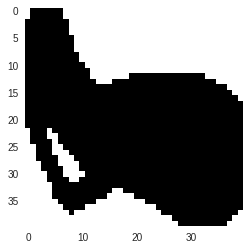

In [7]:
index = 400
example = Y_train[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()

AUGMENT DATA

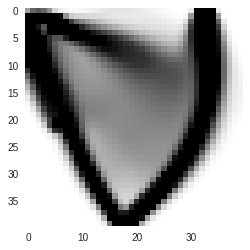

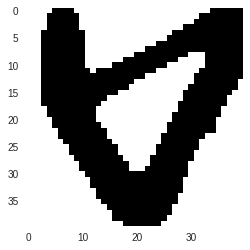

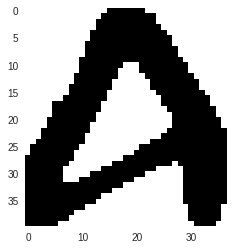

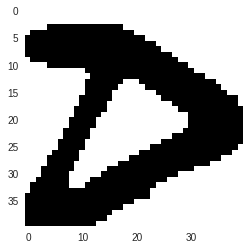

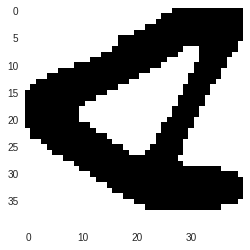

In [18]:
index = 312

example = X_train[index,:,:,0]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()


new_data_X_horiz = np.flip(X_train, axis = 2) # should be 1 and 2
new_data_Y_horiz = np.flip(Y_train, axis = 2)

new_data_X_vert = np.flip(X_train, axis = 1) # should be 1 and 2
new_data_Y_vert = np.flip(Y_train, axis = 1)

new_data_X_rotFor = np.rot90(X_train, k = 1, axes = (1,2)) # should be 1 and 2
new_data_Y_rotFor = np.rot90(Y_train, k = 1, axes = (1,2))

new_data_X_rotBack = np.rot90(X_train, k = 3, axes = (1,2)) # should be 1 and 2
new_data_Y_rotBack = np.rot90(Y_train, k = 3, axes = (1,2))

# CHECK
example = new_data_Y_horiz[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()
example = new_data_Y_vert[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()

example = new_data_Y_rotFor[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()

example = new_data_Y_rotBack[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.grid(False)
plt.show()


X_train= np.concatenate((X_train, new_data_X_horiz, new_data_X_vert, new_data_X_rotFor, new_data_X_rotBack), axis = 0)
Y_train = np.concatenate((Y_train, new_data_Y_horiz, new_data_Y_vert, new_data_Y_rotFor, new_data_Y_rotBack), axis = 0)

In [19]:
print ("number of training examples = " + str(X_train.shape[0]))
#print ("number of dev examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
#print ("X_dev shape: " + str(X_dev.shape))
#print ("Y_dev shape: " + str(Y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 40000
number of test examples = 1000
X_train shape: (40000, 40, 40, 2)
Y_train shape: (40000, 40, 40)
X_test shape: (1000, 40, 40, 2)
Y_test shape: (1000, 40, 40)


FRAMEWORK FUNCTIONS

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, shape = [None, n_H0, n_W0, n_C0], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [None, n_y], name = 'Y')
    ### END CODE HERE ###
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 16]
                        W2 : [2, 2, 16, ]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
    
    f1 = 16
    f2 = 32
    f3 = 64
    n_c = 2
    
    W1 = tf.get_variable("W1", [3,3,n_c,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [3,3,f1,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1, "W2": W2}
    
    return parameters

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    Arguments:
      X -- input data, of shape (number of examples, image_x, image_y)
      Y -- true "label" vector, of shape (number of examples,1)
    Returns:
      mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y) """
    
    # INITIALIZATION
    np.random.seed(seed)
    m = X.shape[0]
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]                     # [m,40,40]
    shuffled_Y = Y[permutation,:,:].reshape((m,40*40))  # [m,40*40]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    
    # number of mini batches of size mini_batch_size in your partitioning 
    for k in range(0, num_complete_minibatches):
      mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size,:,:] #[64,40,40]
      mini_batch_X = mini_batch_X.reshape((mini_batch_size, shuffled_X.shape[1], shuffled_X.shape[2], shuffled_X.shape[3]))
      
      mini_batch_Y = shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size,:]  #[m,1600]

      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
      mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:m,:,:] 
      mini_batch_X = mini_batch_X.reshape(((m-mini_batch_size*(m%mini_batch_size)), shuffled_X.shape[1], shuffled_X.shape[2], shuffled_X.shape[3]))
      
      mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:m,:]
      
      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)
    
    return mini_batches

def forward_propagation(X, parameters, phase):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    keep_probability = 1
    bn = False

    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B1 = tf.contrib.layers.batch_norm(Z1, center = True, scale = True, is_training = phase)
        Z1 = B1
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # DROPOUT
    D1 = tf.nn.dropout(P1, keep_prob = keep_probability)
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(D1,W2, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    if bn == True:
        B2 = tf.contrib.layers.batch_norm(Z2, center = True, scale = True, is_training = phase)
        Z2 = B2
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # FLATTEN
    #Z3 = tf.nn.conv2d(A2, W3, strides = [1,1,1,1], padding = 'SAME')
    F3 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(F3, num_outputs = 40*40, activation_fn = None)
    
    return Z3

def compute_cost(Z, Y):
    """
    Computes the cost

    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (40*40, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    my_logits=tf.reshape(Z, (-1,1))
    my_labels=tf.reshape(Y, (-1,1))
    binary_labels = tf.nn.sigmoid(my_logits) > 0.5
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=my_logits, labels=my_labels))
    mean_IOU = tf.metrics.mean_iou(labels = my_labels, predictions = binary_labels, num_classes = 2)
    accuracy = tf.metrics.accuracy(labels = my_labels, predictions = binary_labels)
    
    return cost, mean_IOU, accuracy


In [0]:
def print_topology(data):
    """
    Arguments:
      data -- image of size (40,40,1)
    Returns:
      nothing
    """
    fig = plt.figure()
    plt.imshow(data[:,:,0], cmap="binary")
    plt.grid(False)
    plt.show()
    return
  

RUN MODEL

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 40, 40, 1)
    Y_train -- test set, of shape (None, n_y)
    X_test -- training set, of shape (None, 40, 40, 1)
    Y_test -- test set, of shape (None, n_y)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]*Y_train.shape[2]  
    
    costs = []
    costs_dev = []
    IOU = []
    IOU_dev = []
    acc = []
    acc_dev = []
    
    number = 27
    
    # TEMPORARY CODE
    X_dev = X_test
    #X_dev = X_dev.reshape((X_dev.shape[0], X_dev.shape[1], X_dev.shape[2],2))

    Y_dev = Y_test
    
    # RESHAPE INPUTS
    Y_dev = Y_dev.reshape((Y_dev.shape[0], Y_dev.shape[1]*Y_dev.shape[2]))

    # PLACEHOLDERS
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    phase = tf.placeholder(tf.bool)

    # INITIALIZE PARAMETERS
    parameters = initialize_parameters()
    
    # FORWARD PROPAGATION
    Z = forward_propagation(X, parameters, phase)
    
    # COST FUNCTION
    cost, mean_IOU, accuracy = compute_cost(Z, Y) 
    
    # BACKPROPAGATION
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # INITIALIZE ALL VARIABLES GLOBALLY AND LOCALLY
    init = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    # ENCODE IMAGE
    image = tf.reshape(tf.image.convert_image_dtype(Z[number,:], tf.int64), [40, 40,1])
    
 
    # START TENSORFLOW SESSION
    with tf.Session() as sess:
        
        # RUN INITIALIZATION
        sess.run(init)
        sess.run(init_local)
        
        # TRAINING LOOP
        for epoch in range(num_epochs):
            print(epoch)
            
            minibatch_cost = 0.
            minibatch_IOU = 0.
            minibatch_acc = 0.
            
            num_minibatches = int(m / minibatch_size)
            
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            # MINIBATCH LOOP
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                _ , temp_cost, image_enc, IOU_current, accuracy_current = sess.run([optimizer, cost, image, mean_IOU, accuracy], feed_dict = {X: minibatch_X, Y: minibatch_Y, phase: True})

                minibatch_cost += temp_cost / num_minibatches
                minibatch_IOU += IOU_current[0] / num_minibatches
                minibatch_acc += accuracy_current[0]/ num_minibatches
            
            # CALCULATE DEV SET COST + IOU EACH EPOCH
            temp_cost_dev, temp_IOU_dev, temp_acc_dev, image_enc_test = sess.run([cost, mean_IOU, accuracy, image], feed_dict = {X:X_dev, Y:Y_dev, phase: False})
            
            # PRINT COST EVERY 5 EPOCHS
            if print_cost == True and epoch == 0:
                print_topology(X_dev[number,:,:,:])
                print_topology(np.reshape(Y_dev[number,:], (40, 40,1)))
            
            if print_cost == True and epoch % 5 == 0:
                print_topology(image_enc_test)
                print ("TRAIN COST @ EPOCH %i: %f" % (epoch, minibatch_cost))
                print ("TRAIN IOU  @ EPOCH %i: %f" % (epoch, minibatch_IOU))
                print ("TRAIN ACC  @ EPOCH %i: %f" % (epoch, minibatch_acc))
                print ("TEST  COST @ EPOCH %i: %f" % (epoch, temp_cost_dev))
                print ("TEST  IOU  @ EPOCH %i: %f" % (epoch, temp_IOU_dev[0]))
                print ("TEST  ACC  @ EPOCH %i: %f" % (epoch, temp_acc_dev[0]))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                costs_dev.append(temp_cost_dev)
                IOU.append(minibatch_IOU)
                IOU_dev.append(temp_IOU_dev[0])
                acc.append(minibatch_acc)
                acc_dev.append(temp_acc_dev[0])
        
        # PLOT COST AND IOU
        plt.plot(np.squeeze(costs), 'b', np.squeeze(costs_dev), 'g')
        plt.ylabel('COST')
        plt.xlabel('iterations (per tens)')
        plt.title("COST (Learning rate =" + str(learning_rate) + ")")
        plt.show()
        
        plt.plot(np.squeeze(IOU), 'b', np.squeeze(IOU_dev), 'g')
        plt.ylabel('IOU')
        plt.xlabel('iterations (per tens)')
        plt.title("IOU")
        plt.show()
        
        plt.plot(np.squeeze(acc), 'b', np.squeeze(acc_dev), 'g')
        plt.ylabel('ACC')
        plt.xlabel('iterations (per tens)')
        plt.title("ACC")
        plt.show()
        
#         # PLOT DEV COST AND IOU
#         plt.plot(np.squeeze(costs_dev))
#         plt.ylabel('COST')
#         plt.xlabel('iterations (per tens)')
#         plt.title("COST (DEV SET) (Learning rate =" + str(learning_rate) + ")")
#         plt.show()
        
#         plt.plot(np.squeeze(IOU_dev))
#         plt.ylabel('IOU')
#         plt.xlabel('iterations (per tens)')
#         plt.title("IOU (DEV SET):")
#         plt.show()
           
        return parameters, costs, IOU, acc, costs_dev, IOU_dev, acc_dev

0


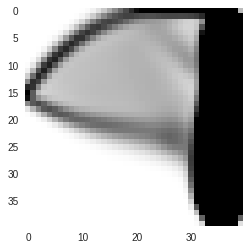

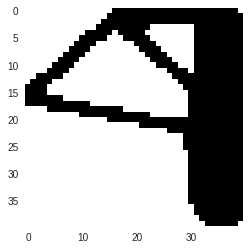

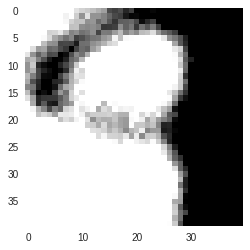

TRAIN COST @ EPOCH 0: 0.394048
TRAIN IOU  @ EPOCH 0: 0.584013
TRAIN ACC  @ EPOCH 0: 0.732680
TEST  COST @ EPOCH 0: 0.261793
TEST  IOU  @ EPOCH 0: 0.691671
TEST  ACC  @ EPOCH 0: 0.817802
1
2
3
4
5


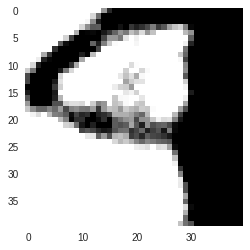

TRAIN COST @ EPOCH 5: 0.175914
TRAIN IOU  @ EPOCH 5: 0.818678
TRAIN ACC  @ EPOCH 5: 0.900298
TEST  COST @ EPOCH 5: 0.170235
TEST  IOU  @ EPOCH 5: 0.822534
TEST  ACC  @ EPOCH 5: 0.902626
6
7
8
9
10


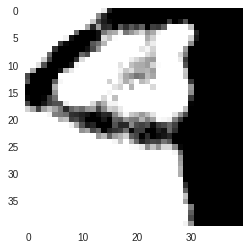

TRAIN COST @ EPOCH 10: 0.160809
TRAIN IOU  @ EPOCH 10: 0.843851
TRAIN ACC  @ EPOCH 10: 0.915315
TEST  COST @ EPOCH 10: 0.157352
TEST  IOU  @ EPOCH 10: 0.845335
TEST  ACC  @ EPOCH 10: 0.916187
11
12
13
14
15


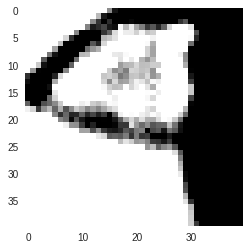

TRAIN COST @ EPOCH 15: 0.153171
TRAIN IOU  @ EPOCH 15: 0.855468
TRAIN ACC  @ EPOCH 15: 0.922107
TEST  COST @ EPOCH 15: 0.150642
TEST  IOU  @ EPOCH 15: 0.856298
TEST  ACC  @ EPOCH 15: 0.922590
16
17
18
19
20


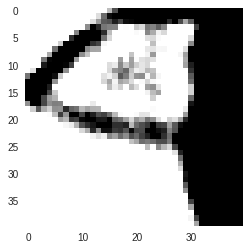

TRAIN COST @ EPOCH 20: 0.148042
TRAIN IOU  @ EPOCH 20: 0.862567
TRAIN ACC  @ EPOCH 20: 0.926216
TEST  COST @ EPOCH 20: 0.146199
TEST  IOU  @ EPOCH 20: 0.863126
TEST  ACC  @ EPOCH 20: 0.926538
21
22
23
24
25


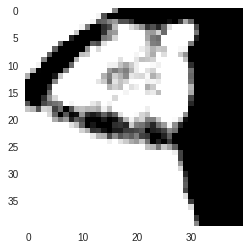

TRAIN COST @ EPOCH 25: 0.144099
TRAIN IOU  @ EPOCH 25: 0.867541
TRAIN ACC  @ EPOCH 25: 0.929076
TEST  COST @ EPOCH 25: 0.142961
TEST  IOU  @ EPOCH 25: 0.867957
TEST  ACC  @ EPOCH 25: 0.929315
26
27
28
29
30


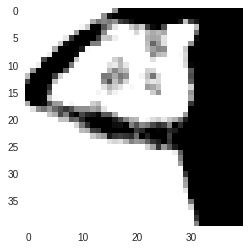

TRAIN COST @ EPOCH 30: 0.140847
TRAIN IOU  @ EPOCH 30: 0.871327
TRAIN ACC  @ EPOCH 30: 0.931246
TEST  COST @ EPOCH 30: 0.140864
TEST  IOU  @ EPOCH 30: 0.871647
TEST  ACC  @ EPOCH 30: 0.931429
31
32
33
34
35


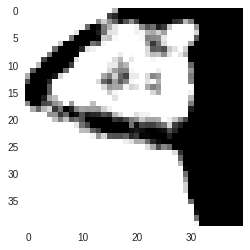

TRAIN COST @ EPOCH 35: 0.137999
TRAIN IOU  @ EPOCH 35: 0.874348
TRAIN ACC  @ EPOCH 35: 0.932968
TEST  COST @ EPOCH 35: 0.138385
TEST  IOU  @ EPOCH 35: 0.874614
TEST  ACC  @ EPOCH 35: 0.933120
36
37
38
39
40


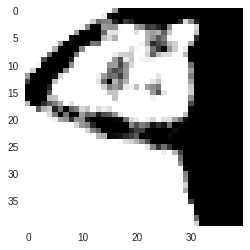

TRAIN COST @ EPOCH 40: 0.135484
TRAIN IOU  @ EPOCH 40: 0.876863
TRAIN ACC  @ EPOCH 40: 0.934399
TEST  COST @ EPOCH 40: 0.136772
TEST  IOU  @ EPOCH 40: 0.877090
TEST  ACC  @ EPOCH 40: 0.934529
41
42
43
44
45


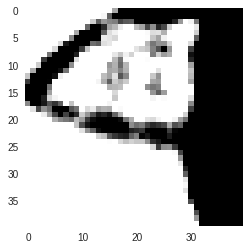

TRAIN COST @ EPOCH 45: 0.133034
TRAIN IOU  @ EPOCH 45: 0.879016
TRAIN ACC  @ EPOCH 45: 0.935622
TEST  COST @ EPOCH 45: 0.135072
TEST  IOU  @ EPOCH 45: 0.879212
TEST  ACC  @ EPOCH 45: 0.935732
46
47
48
49
50


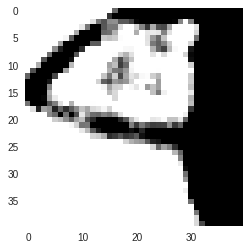

TRAIN COST @ EPOCH 50: 0.130723
TRAIN IOU  @ EPOCH 50: 0.880910
TRAIN ACC  @ EPOCH 50: 0.936694
TEST  COST @ EPOCH 50: 0.133121
TEST  IOU  @ EPOCH 50: 0.881082
TEST  ACC  @ EPOCH 50: 0.936791
51
52
53
54
55


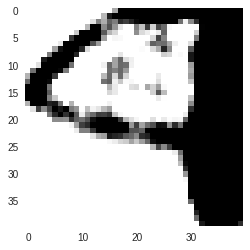

TRAIN COST @ EPOCH 55: 0.128586
TRAIN IOU  @ EPOCH 55: 0.882599
TRAIN ACC  @ EPOCH 55: 0.937649
TEST  COST @ EPOCH 55: 0.131899
TEST  IOU  @ EPOCH 55: 0.882755
TEST  ACC  @ EPOCH 55: 0.937737
56
57
58
59
60


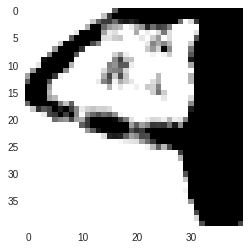

TRAIN COST @ EPOCH 60: 0.126602
TRAIN IOU  @ EPOCH 60: 0.884124
TRAIN ACC  @ EPOCH 60: 0.938511
TEST  COST @ EPOCH 60: 0.130346
TEST  IOU  @ EPOCH 60: 0.884264
TEST  ACC  @ EPOCH 60: 0.938590
61
62
63
64
65


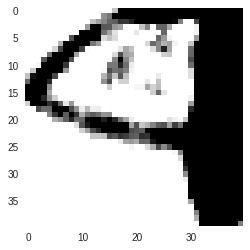

TRAIN COST @ EPOCH 65: 0.124835
TRAIN IOU  @ EPOCH 65: 0.885508
TRAIN ACC  @ EPOCH 65: 0.939289
TEST  COST @ EPOCH 65: 0.129695
TEST  IOU  @ EPOCH 65: 0.885638
TEST  ACC  @ EPOCH 65: 0.939361
66
67
68
69
70


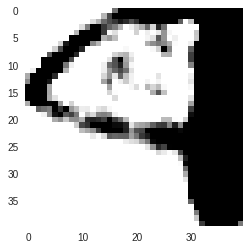

TRAIN COST @ EPOCH 70: 0.123255
TRAIN IOU  @ EPOCH 70: 0.886776
TRAIN ACC  @ EPOCH 70: 0.940003
TEST  COST @ EPOCH 70: 0.128726
TEST  IOU  @ EPOCH 70: 0.886895
TEST  ACC  @ EPOCH 70: 0.940070
71
72
73
74
75


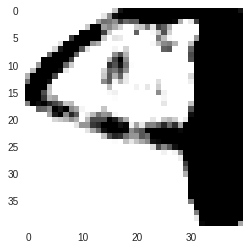

TRAIN COST @ EPOCH 75: 0.121802
TRAIN IOU  @ EPOCH 75: 0.887947
TRAIN ACC  @ EPOCH 75: 0.940659
TEST  COST @ EPOCH 75: 0.127934
TEST  IOU  @ EPOCH 75: 0.888054
TEST  ACC  @ EPOCH 75: 0.940721
76
77
78
79
80


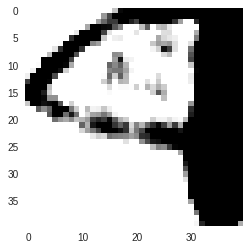

TRAIN COST @ EPOCH 80: 0.120495
TRAIN IOU  @ EPOCH 80: 0.889026
TRAIN ACC  @ EPOCH 80: 0.941266
TEST  COST @ EPOCH 80: 0.127465
TEST  IOU  @ EPOCH 80: 0.889127
TEST  ACC  @ EPOCH 80: 0.941323
81
82
83
84
85


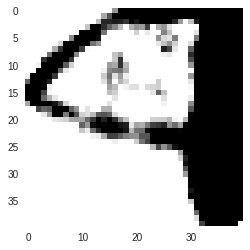

TRAIN COST @ EPOCH 85: 0.119270
TRAIN IOU  @ EPOCH 85: 0.890032
TRAIN ACC  @ EPOCH 85: 0.941831
TEST  COST @ EPOCH 85: 0.126636
TEST  IOU  @ EPOCH 85: 0.890126
TEST  ACC  @ EPOCH 85: 0.941883
86
87
88
89
90


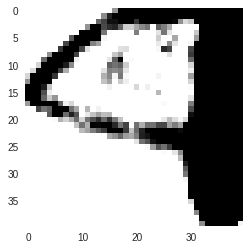

TRAIN COST @ EPOCH 90: 0.118125
TRAIN IOU  @ EPOCH 90: 0.890970
TRAIN ACC  @ EPOCH 90: 0.942354
TEST  COST @ EPOCH 90: 0.126367
TEST  IOU  @ EPOCH 90: 0.891058
TEST  ACC  @ EPOCH 90: 0.942404
91
92
93
94
95


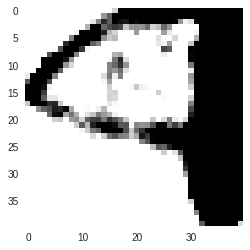

TRAIN COST @ EPOCH 95: 0.117085
TRAIN IOU  @ EPOCH 95: 0.891848
TRAIN ACC  @ EPOCH 95: 0.942847
TEST  COST @ EPOCH 95: 0.126001
TEST  IOU  @ EPOCH 95: 0.891932
TEST  ACC  @ EPOCH 95: 0.942894
96
97
98
99


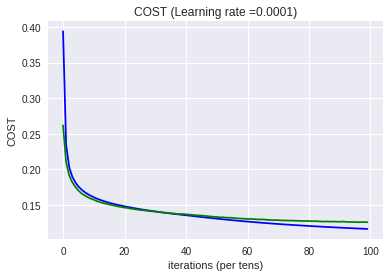

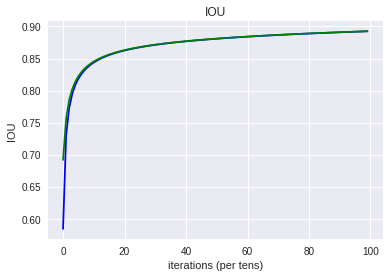

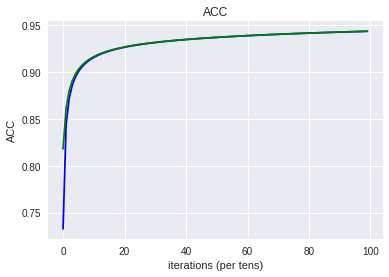

({'W1': <tf.Variable 'W1:0' shape=(3, 3, 2, 16) dtype=float32_ref>,
  'W2': <tf.Variable 'W2:0' shape=(3, 3, 16, 16) dtype=float32_ref>},
 [0.3940480096101763,
  0.23439330677986156,
  0.2031878729343416,
  0.18979289891719817,
  0.18165697696208957,
  0.1759143703937534,
  0.17160161013603203,
  0.16816747703552243,
  0.16530467531681048,
  0.16288601982593542,
  0.16080935094356533,
  0.15890870156288137,
  0.15724616646766654,
  0.15575392110347736,
  0.15436786863803872,
  0.1531712997913361,
  0.15196170936822886,
  0.15091489994525903,
  0.14989838975667963,
  0.14896482430696498,
  0.14804223219156257,
  0.14720359990596774,
  0.14638134070634842,
  0.14559405298233027,
  0.14485651570558544,
  0.1440994394302369,
  0.14343326274156562,
  0.14274628446102156,
  0.14206898033618928,
  0.14149722913503673,
  0.1408468952536584,
  0.14025322173833857,
  0.1396842098951339,
  0.13910995757579805,
  0.1385873662590981,
  0.13799903397560134,
  0.13746705763339997,
  0.136995773863792

In [32]:
model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 100, minibatch_size = 64, print_cost = True)